# Kaggle: Sberbank Russian Housing Prices Regression

Dropped 1M, 2M, 3M points and imputed their values.

In [1]:
#######################
### Import Packages ###
#######################

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

import seaborn as sns;

from scipy import stats;

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [79]:
#########################
### Import Data Files ###
#########################

macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]

df_train = pd.read_csv("train.csv", parse_dates=['timestamp'])
df_test  = pd.read_csv("test.csv",  parse_dates=['timestamp'])
df_macro = pd.read_csv("macro.csv", parse_dates=['timestamp'], usecols=['timestamp'] + macro_cols)

num_train_cleandirty = len(df_train)
num_test = len(df_test)

# Define id varaibles
id_test = df_test['id']

# Drop ID  
df_train.drop(['id'], axis=1, inplace=True)
df_test.drop( ['id'], axis=1, inplace=True)

In [80]:
# Build df_all = (df_train+df_test).join(df_macro)
df_all = pd.concat([df_train, df_test])
df_all = pd.merge_ordered(df_all, df_macro, on='timestamp', how='left')

# Add month-year
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek

# Other feature engineering
df_all['rel_floor']      = df_all['floor'] / df_all['max_floor'].astype(float)
df_all['rel_kitch_sq']   = df_all['kitch_sq'] / df_all['full_sq'].astype(float)
df_all['apartment_name'] = df_all['sub_area'] + df_all['metro_km_avto'].astype(str) + df_all['month_year_cnt'].astype(str)
df_all['floor_from_top'] = df_all['max_floor'].astype(float) - df_all['floor']
df_all['avg_room_size']  = (df_all['life_sq'] - df_all['kitch_sq'])/df_all['num_room']
df_all['living_propor']  = df_all['life_sq'] / df_all['full_sq']
df_all['kitchen_prop']   = df_all['kitch_sq'] / df_all['full_sq']
df_all['extra_area']     = df_all['full_sq'] - df_all['life_sq']

df_all['young_prop']     = df_all['young_all'] / df_all['full_all']
df_all['work_prop']      = df_all['work_all']  / df_all['full_all']
df_all['retire_prop']    = df_all['ekder_all'] / df_all['full_all']

df_all['ratio_preschool'] = df_all['children_preschool'] / df_all['preschool_quota']
df_all['ratio_school ']   = df_all['children_school'] / df_all['school_quota']
    
df_all['pop_density_raion '] = df_all['raion_popul'] / df_all['area_m']
    
# Remove timestamp column (may overfit the model in train)
df_all.drop(['timestamp'], axis=1, inplace=True)

# Deal with categorical values
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj     = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_all = pd.concat([df_numeric, df_obj], axis=1)

print(np.shape(df_all))

(38133, 319)


In [81]:
#########################
### Clean Up Outliers ###
#########################

df_all.loc[df_all['life_sq'] > 1000,     'life_sq']       = np.median(df_all['life_sq'].dropna());
df_all.loc[df_all['kitch_sq'] > 250,     'kitch_sq']      = np.median(df_all['kitch_sq'].dropna());
df_all.loc[df_all['num_room'] > 6,       'num_room']      = np.median(df_all['num_room'].dropna());
df_all.loc[df_all['build_year'] > 2017,  'build_year']    = np.median(df_all['build_year'].dropna());
df_all.loc[df_all['build_year'] < 1800,  'build_year']    = np.median(df_all['build_year'].dropna());
df_all.loc[df_all['floor'] > 50,         'floor']         = np.median(df_all['floor'].dropna());
df_all.loc[df_all['max_floor'] > 60,     'max_floor']     = np.median(df_all['max_floor'].dropna());
df_all.loc[df_all['metro_km_walk'] > 30, 'metro_km_walk'] = np.median(df_all['metro_km_walk'].dropna());

In [82]:
############################
### Convert to Densities ###
############################

df_all['0_6_all']      = df_all['0_6_all'] / df_all['area_m']
df_all['0_6_male']     = df_all['0_6_male'] / df_all['area_m']
df_all['0_6_female']   = df_all['0_6_female'] / df_all['area_m']
df_all['7_14_all']     = df_all['7_14_all'] / df_all['area_m']
df_all['7_14_male']    = df_all['7_14_male'] / df_all['area_m']
df_all['7_14_female']  = df_all['7_14_female'] / df_all['area_m']
df_all['0_17_all']     = df_all['0_17_all'] / df_all['area_m']
df_all['0_17_male']    = df_all['0_17_male'] / df_all['area_m']
df_all['0_17_female']  = df_all['0_17_female'] / df_all['area_m']
df_all['16_29_all']    = df_all['16_29_all'] / df_all['area_m']
df_all['16_29_male']   = df_all['16_29_male'] / df_all['area_m']
df_all['16_29_female'] = df_all['16_29_female'] / df_all['area_m']
df_all['0_13_all']     = df_all['0_17_all'] / df_all['area_m']
df_all['0_13_male']    = df_all['0_17_male'] / df_all['area_m']
df_all['0_13_female']  = df_all['0_17_female'] / df_all['area_m']

In [83]:
#####################################
### Simplify Repetative Variables ###
#####################################

to_simplify = ['cafe_count_500_price', 'cafe_count_1000_price', 'cafe_count_1500_price', 'cafe_count_2000_price', 
               'cafe_count_3000_price', 'cafe_count_5000_price', 'cafe_avg', 'min_price', 'max_price', 'na_price',
               'big_church_count', 'church_count', 'mosque_count', 'leisure_count', 'sport_count', 'office_count', 
               'market_count', 'trc_sqm', 'trc_count', 'prom_part', 'green_part']

for col_simplify in to_simplify:
    df_all[col_simplify] = 0;
    
    for column in df_all.columns.values:
        if column.find(col_simplify) > -1:
            df_all[col_simplify] = df_all[col_simplify] + df_all[column];
            df_all = df_all.drop(column, axis=1)

In [84]:
############################################
### Remove Highly Uncorrelated Variables ###
############################################

print(len(df_all.columns.values))

for column in df_all.columns.values:
    if abs(df_all[column].corr(df_all['price_doc'])) < 0.05:
        df_all = df_all.drop(column, axis=1)
        
print(len(df_all.columns.values))

193
154


In [85]:
######################################
### Log Normalize Skewed Variables ###
######################################

for column in df_all.columns.values:
    if stats.skew(df_all[column].values) > 1:
        df_all[column] = np.log(df_all[column] + 1)   

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: invalid value encountered in log


In [86]:
#########################################
### Split Training Set by "Normality" ###
#########################################

df_dirty = df_all[(df_all.price_doc == 1000000) | (df_all.price_doc == 2000000) | (df_all.price_doc == 3000000)]
df_dirty = df_dirty.drop('price_doc', axis=1)

df_clean = df_all[(df_all.price_doc != 1000000) & (df_all.price_doc != 2000000) & (df_all.price_doc != 3000000)]

num_train_clean = len(df_clean)

# Define log and id varaibles
ylog_clean_all = np.log1p(df_clean['price_doc'].values)
#ylog_clean_all = df_clean['price_doc'].values
df_clean = df_clean.drop('price_doc', axis=1)

print(np.shape(ylog_clean_all))
print(np.shape(df_clean))
print(np.shape(df_dirty))

(36297,)
(36297, 153)
(1836, 153)


In [87]:
num_train = num_train_clean - num_test

# Convert to numpy values
X_all_clean = df_clean.values
print('X_all_clean shape is',       X_all_clean.shape)

# Create a validation set, with last 20% of data
num_val = int(num_train * 0.2)

X_train_all_clean = X_all_clean[:num_train]
X_train_clean     = X_all_clean[:num_train-num_val]
X_val_clean       = X_all_clean[num_train-num_val:num_train]
ylog_train_clean  = ylog_clean_all[:num_train-num_val]
ylog_val_clean    = ylog_clean_all[num_train-num_val:num_train]

X_test = X_all_clean[num_train:]

df_columns = df_clean.columns

print('X_train_all_clean shape is', X_train_all_clean.shape)
print('X_train_clean shape is',     X_train_clean.shape)
print('ylog_train_clean shape is',  ylog_train_clean.shape)
print('X_val_clean shape is',       X_val_clean.shape)
print('ylog_val_clean shape is',    ylog_val_clean.shape)
print('X_test shape is',            X_test.shape)

X_all_clean shape is (36297, 153)
X_train_all_clean shape is (28635, 153)
X_train_clean shape is (22908, 153)
ylog_train_clean shape is (22908,)
X_val_clean shape is (5727, 153)
ylog_val_clean shape is (5727,)
X_test shape is (7662, 153)


In [88]:
# Define XGB DMatrices

dtrain_all = xgb.DMatrix(X_train_all_clean, ylog_clean_all,   feature_names=df_columns)
dtrain     = xgb.DMatrix(X_train_clean,     ylog_train_clean, feature_names=df_columns)
dval       = xgb.DMatrix(X_val_clean,       ylog_val_clean,   feature_names=df_columns)
dtest      = xgb.DMatrix(X_test,                              feature_names=df_columns)

In [90]:
xgb_params = {
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

[0]	val-rmse:14.8506
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:8.12896
[40]	val-rmse:4.47472
[60]	val-rmse:2.48869
[80]	val-rmse:1.41172
[100]	val-rmse:0.836403
[120]	val-rmse:0.536772
[140]	val-rmse:0.389644
[160]	val-rmse:0.322852
[180]	val-rmse:0.294102
[200]	val-rmse:0.279641
[220]	val-rmse:0.27289
[240]	val-rmse:0.269286
[260]	val-rmse:0.2671
[280]	val-rmse:0.265918
[300]	val-rmse:0.265068
[320]	val-rmse:0.264019
[340]	val-rmse:0.263453
[360]	val-rmse:0.262818
[380]	val-rmse:0.262331
[400]	val-rmse:0.262031
[420]	val-rmse:0.261888
[440]	val-rmse:0.261719
[460]	val-rmse:0.262034
Stopping. Best iteration:
[440]	val-rmse:0.261719



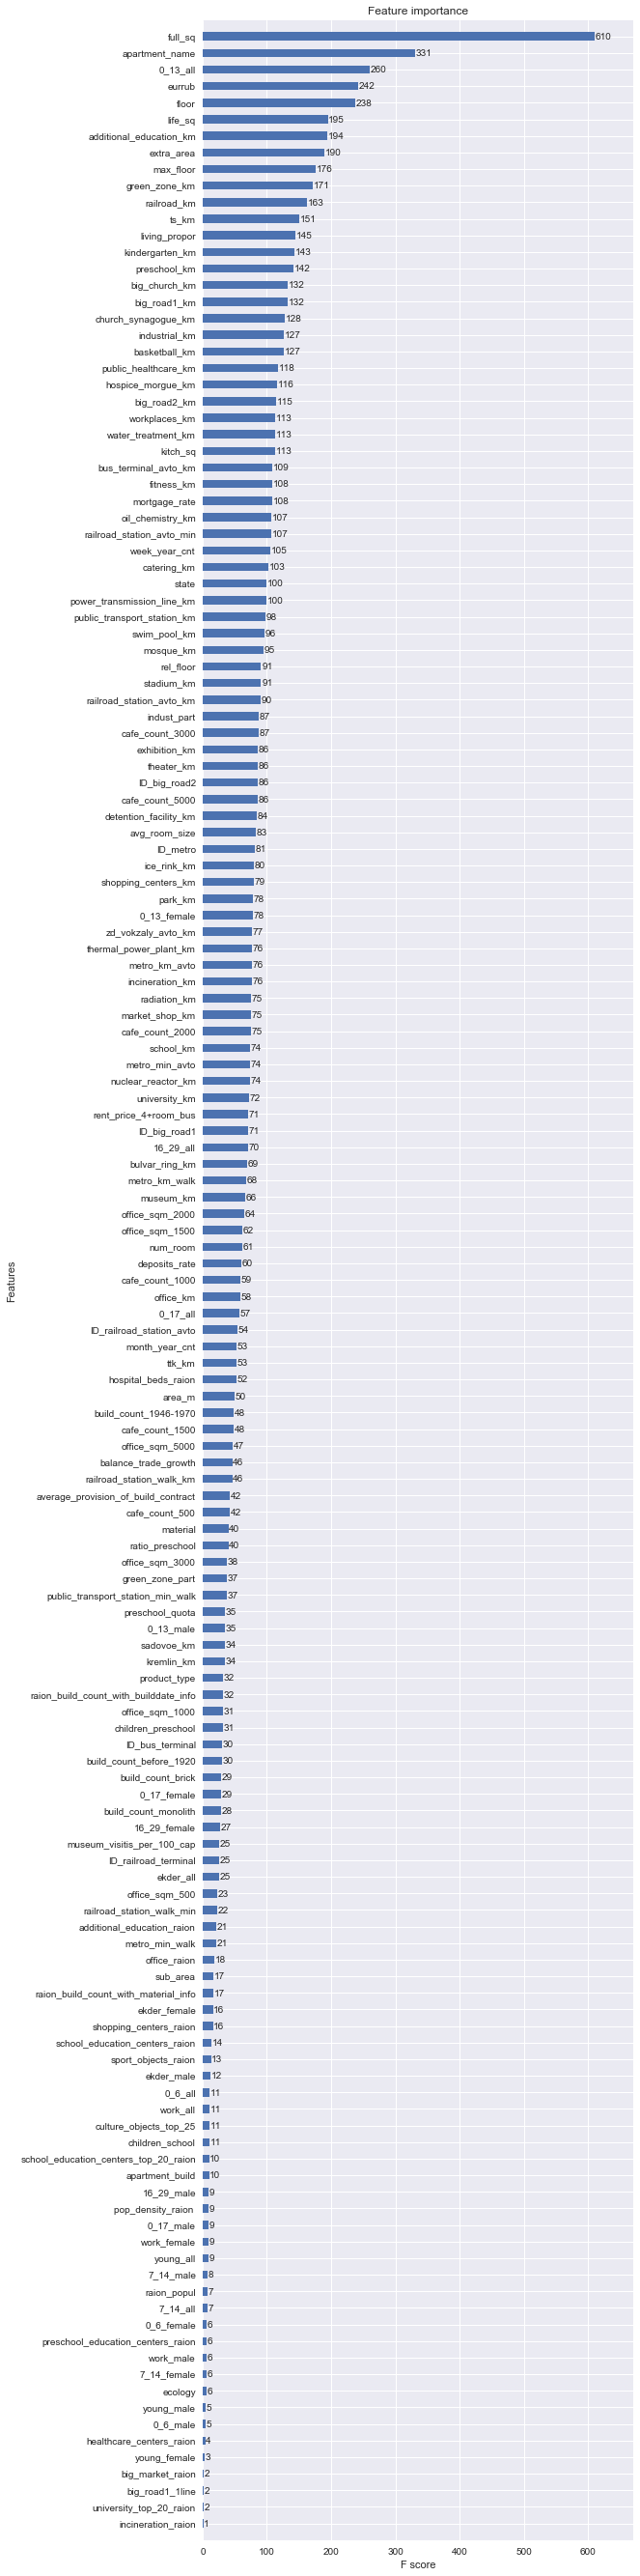

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(8, 48))
xgb.plot_importance(partial_model, height=0.5, ax=ax)

In [92]:
X_dirty     = df_dirty.values

print('X_dirty shape is',       X_dirty.shape)

d_dirty      = xgb.DMatrix(X_dirty,                              feature_names=df_columns)

X_dirty shape is (1836, 153)


In [93]:
# Now Impute the Missing Price Doc Values, and Retrain with Validation

ylog_missing = partial_model.predict(d_dirty)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(13, 18)

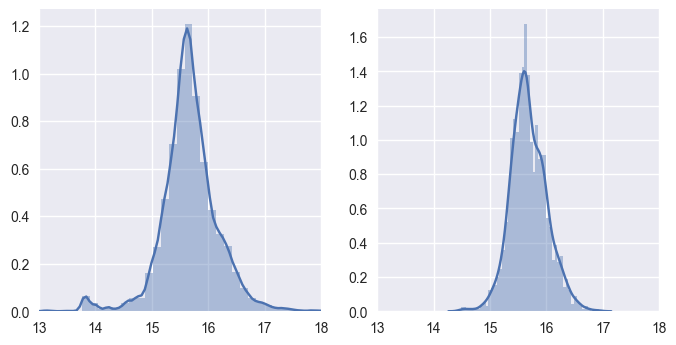

In [94]:
fig  = plt.figure(figsize=(8, 4), dpi=100);

axes1 = fig.add_subplot(121); 
axes2 = fig.add_subplot(122); 

sns.distplot(ylog_train_clean, bins=50, ax=axes1)
sns.distplot(ylog_missing, bins=50, ax=axes2)

axes1.set_xlim(13,18)
axes2.set_xlim(13,18)

In [95]:
X_all = np.concatenate((X_train_clean, X_dirty), axis=0)
y_all = np.concatenate((ylog_train_clean, ylog_missing), axis=0)

print('X_clean shape is',       X_train_clean.shape)
print('X_dirty shape is',       X_dirty.shape)
print('X_all   shape is',       X_all.shape)
print('y_all shape is',         y_all.shape)

X_clean shape is (22908, 153)
X_dirty shape is (1836, 153)
X_all   shape is (24744, 153)
y_all shape is (24744,)


In [96]:
d_all = xgb.DMatrix(X_all, y_all, feature_names=df_columns)

In [97]:
# Train on All Data, Without Validation Set

num_boost_round = partial_model.best_iteration

model = xgb.train(dict(xgb_params, silent=0), d_all, num_boost_round=num_boost_round)

ylog_pred = model.predict(dtest)

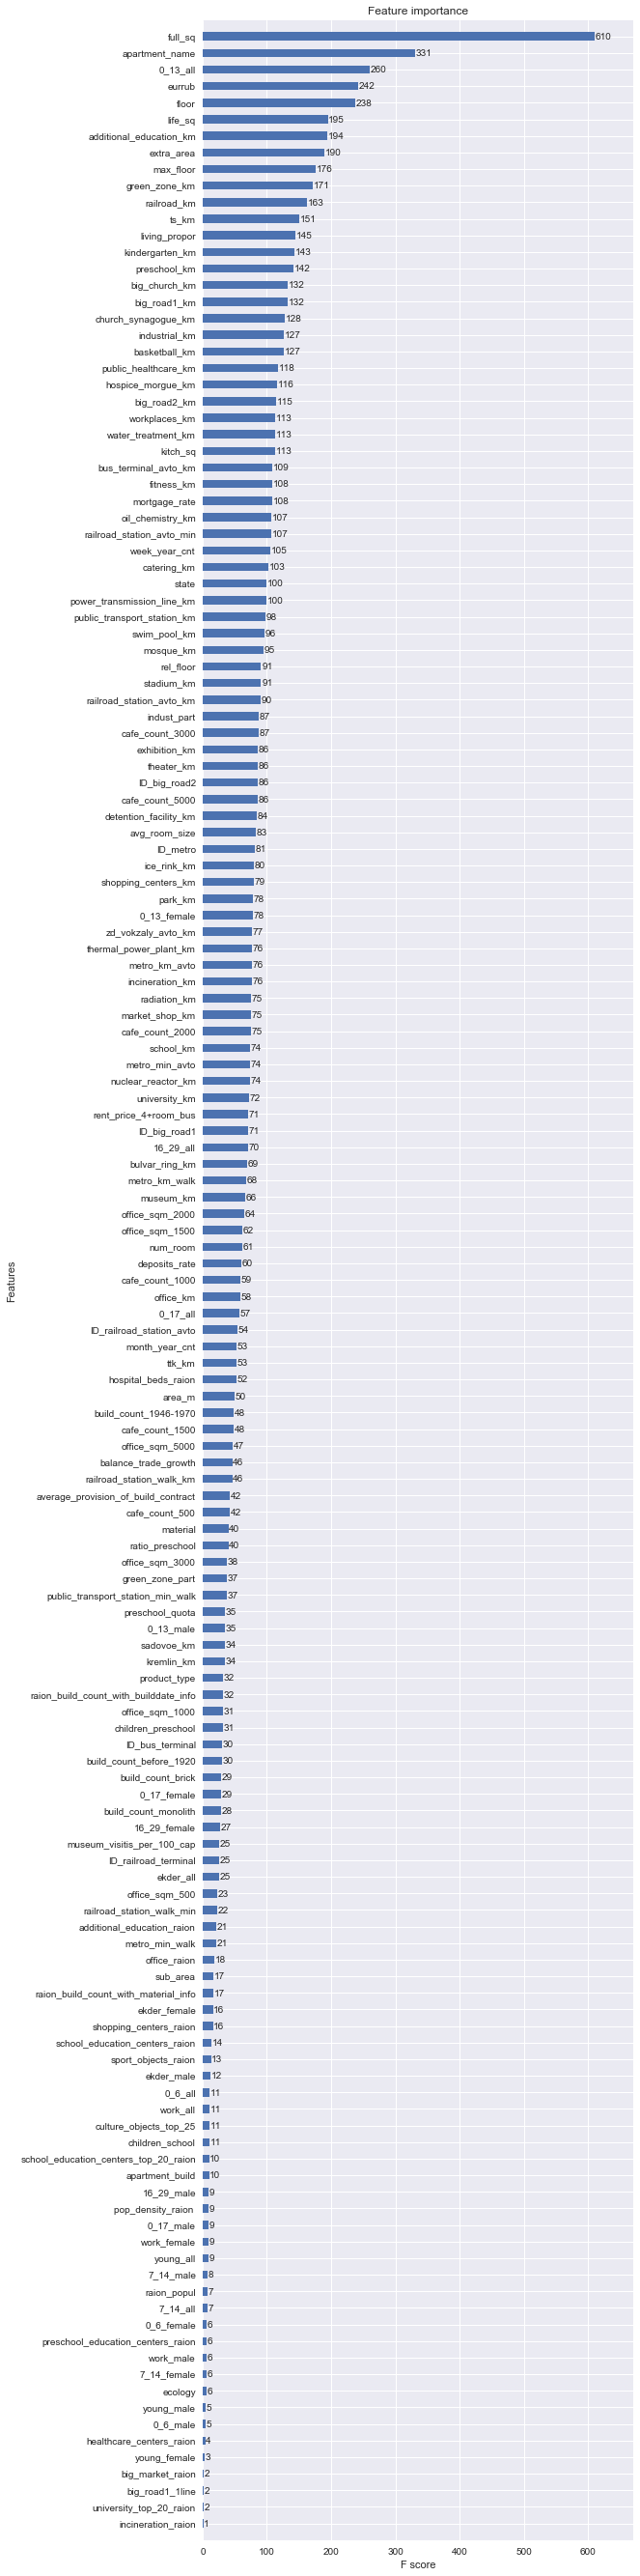

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(8, 48))
xgb.plot_importance(partial_model, height=0.5, ax=ax)

In [99]:
ylog_pred = model.predict(dtest)
y_pred = np.exp(ylog_pred) - 1

df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

df_sub.to_csv('submissions/17_05_23_XGB_Impute123M_NoOutlier_NoSkew_SimpleColumns_MoreNormalizedFeatures_TryAgain.csv', index=False)